### **Load libraries**

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Define ticker names**

In [4]:
col_stock_list_path = 'colombia_stocks_trii.csv'
global_stock_list_path = 'global_stocks_trii.csv'

ticker_list_col = list(pd.read_csv(col_stock_list_path, header=None)[0])
ticker_list_glob = list(pd.read_csv(global_stock_list_path, header=None)[0])

In [5]:
""" Alt method
col_stock_list_path = 'colombia_stocks_trii.csv'
global_stock_list_path = 'global_stocks_trii.csv'

with open(col_stock_list_path) as s:
    ticker_list_col = []
    [ticker_list_col.append(l.replace('\n', '')) for l in s]
    s.close()
with open(global_stock_list_path) as s:
    ticker_list_global = []
    [ticker_list_global.append(l.replace('\n', '')) for l in s]
    s.close()
"""

" Alt method\ncol_stock_list_path = 'colombia_stocks_trii.csv'\nglobal_stock_list_path = 'global_stocks_trii.csv'\n\nwith open(col_stock_list_path) as s:\n    ticker_list_col = []\n    [ticker_list_col.append(l.replace('\n', '')) for l in s]\n    s.close()\nwith open(global_stock_list_path) as s:\n    ticker_list_global = []\n    [ticker_list_global.append(l.replace('\n', '')) for l in s]\n    s.close()\n"

In [6]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 252

### **Extract data from YFinance**

In [7]:
days_of_data = 1200 #790
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=days_of_data)

In [8]:
interval = '1d'   # Uncomment for daily data
#interval = '1wk'  # Uncomment for weekly data
# interval = '1mo' # Uncomment for monthly data

col_stocks_raw = yf.download(ticker_list_col, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']
global_stocks_raw = yf.download(ticker_list_glob, interval=interval, start=start_date, end=end_date, auto_adjust=True)['Close']

[*********************100%***********************]  37 of 37 completed

3 Failed downloads:
['LTMCO.CL', 'NUAMCO.CL', 'GXTESCOL.CL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2021-10-15 -> 2025-01-27)')
[*********************100%***********************]  49 of 49 completed

7 Failed downloads:
['SQMBCO.CL', 'IWVLM.XD', 'ENELAMCO.CL', 'ICHNA.XD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2021-10-15 -> 2025-01-27)')
['LTMCO', 'CFMITNIPCO', 'IBO1']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


### **Preprocessing**

In [9]:
# Assign a frequency to the index of the dataframes
col_stocks_raw.index = col_stocks_raw.index.to_period(freq='D') # Uncomment to set frequency as Daily
global_stocks_raw.index = global_stocks_raw.index.to_period(freq='D') # Uncomment to set ferquency as Daily

# col_stocks_raw.index = col_stocks_raw.index.to_period(freq='W') # Uncomment to set frequency as Weekly
# global_stocks_raw.index = global_stocks_raw.index.to_period(freq='W') # Uncomment to set ferquency as Weekly

# col_stocks_raw.index = col_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly
# global_stocks_raw.index = global_stocks_raw.index.to_period(freq='M') # Uncomment to set frequency as Monthly

C:\Users\jumar\AppData\Local\Temp\ipykernel_38780\553269314.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  col_stocks_raw.index = col_stocks_raw.index.to_period(freq='D') # Uncomment to set frequency as Daily
C:\Users\jumar\AppData\Local\Temp\ipykernel_38780\553269314.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  global_stocks_raw.index = global_stocks_raw.index.to_period(freq='D') # Uncomment to set ferquency as Daily


In [10]:
# Convert from prices into returns
col_rets_raw = col_stocks_raw.pct_change().iloc[1:]
global_rets_raw = global_stocks_raw.pct_change().iloc[1:]

C:\Users\jumar\AppData\Local\Temp\ipykernel_38780\959564986.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  col_rets_raw = col_stocks_raw.pct_change().iloc[1:]
C:\Users\jumar\AppData\Local\Temp\ipykernel_38780\959564986.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  global_rets_raw = global_stocks_raw.pct_change().iloc[1:]


In [11]:
# Check dataset sizes
(col_stocks_raw.shape, col_rets_raw.shape)

((854, 37), (853, 37))

In [12]:
# Define start and end dates of the analysis
days_of_analysis = 260*2   # Daily, 2 years
# days_of_analysis = 7*108   # Weekly, 2 years
end_date = str(datetime.date.today())
start_date = str(datetime.date.today() - datetime.timedelta(days=days_of_analysis))

In [13]:
# Merge Col and Global stock prices and returns data
rets = pd.concat([col_rets_raw, global_rets_raw], axis='columns').sort_index()
stocks = pd.concat([col_stocks_raw, global_stocks_raw], axis='columns').sort_index()
stocks = stocks.loc[:, rets.columns]

In [14]:
rets = rets.loc[start_date:end_date]
stocks = stocks.loc[start_date:end_date]

In [15]:
stocks_not_missing = stocks.columns[stocks.isna().sum() < stocks.shape[0]*.15]

In [16]:
rets = rets[stocks_not_missing].fillna(0)
stocks = stocks[stocks_not_missing].fillna(method='bfill')

C:\Users\jumar\AppData\Local\Temp\ipykernel_38780\2388026509.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stocks = stocks[stocks_not_missing].fillna(method='bfill')


### **Initial examination**

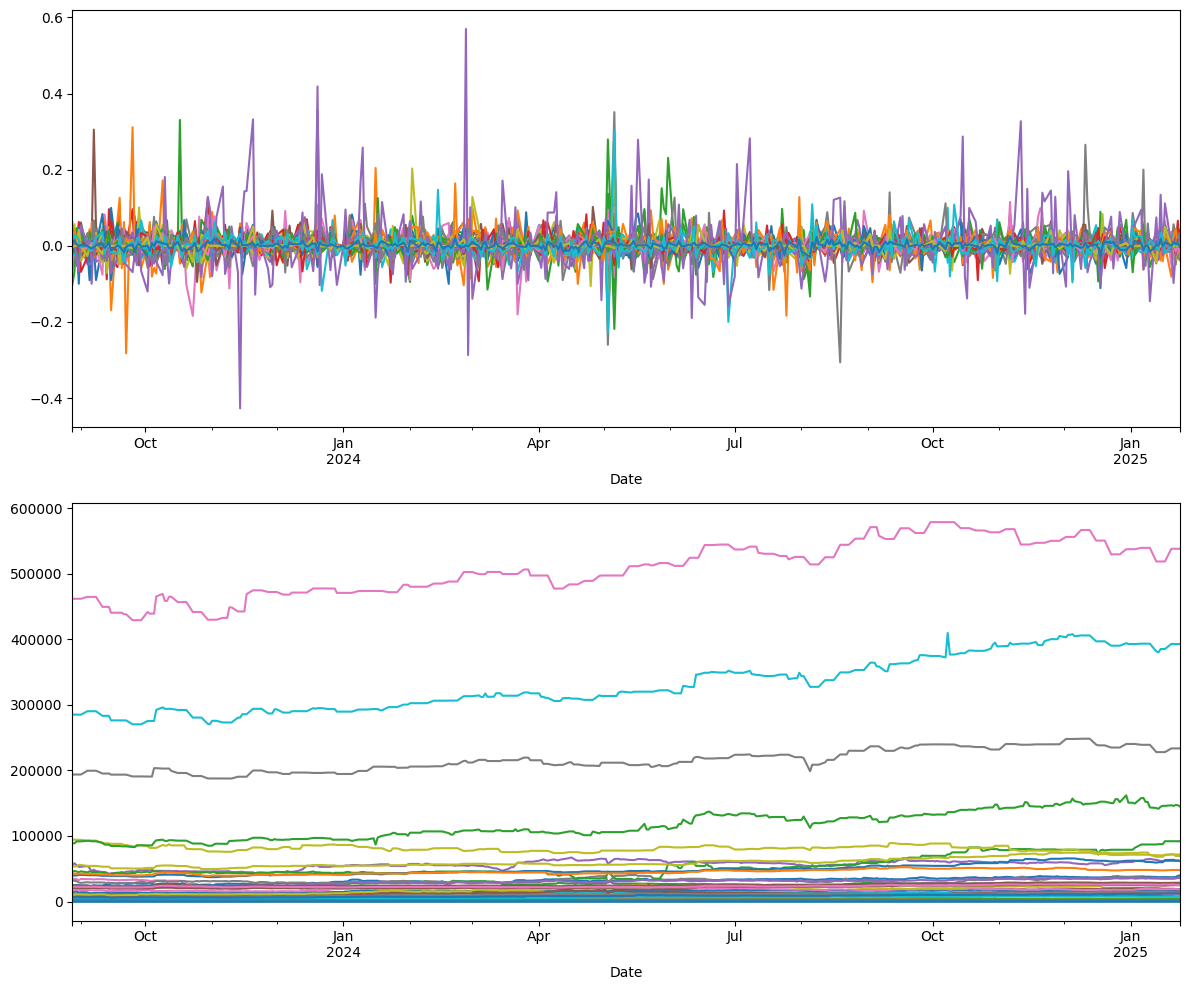

In [17]:
df1_to_plot = rets
df2_to_plot = stocks

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
df1_to_plot.plot(ax = axes[0], legend=False)
df2_to_plot.plot(ax=axes[1], legend=False)
plt.tight_layout()

In [18]:
summary_stats = rk.summary_stats(rets, riskfree_rate=0, periods_per_year=252)
summary_stats

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
BCOLOMBIA.CL,0.391128,0.307314,0.260757,7.001977,0.027322,0.040443,1.272729,-0.170732
BHI.CL,0.237027,0.207723,0.888932,9.704992,0.015323,0.027789,1.141070,-0.109182
BOGOTA.CL,0.079216,0.289167,0.352929,18.298282,0.022000,0.040998,0.273947,-0.242429
BVC.CL,0.177225,0.359447,0.860743,14.129626,0.025402,0.055023,0.493048,-0.222798
CELSIA.CL,0.398728,0.288779,0.487748,9.386538,0.023477,0.037980,1.380737,-0.177687
CEMARGOS.CL,1.359523,0.405373,4.598195,54.772211,-0.031912,0.039561,3.353757,-0.170455
CNEC.CL,-0.555989,0.464352,-1.071442,11.552034,0.054121,0.077431,-1.197343,-0.740479
CONCONCRET.CL,0.819006,0.469338,3.141914,25.473918,0.000545,0.047520,1.745026,-0.218563
CORFICOLCF.CL,0.274582,0.315083,0.530906,4.784620,0.027674,0.039346,0.871459,-0.305882


### **Technical Indicators for selected stock**

In [19]:
# Determine a number of periods for the calculation of the moving averages
MA_terms = 5*4

,NVDA,SMA20,EMA20,SMA20 Signal,EMA20 Signal,MACD Signal
Date,,,,,,
2023-08-28,46.813751,NaN,46.813751,False,False,False
2023-08-29,48.761868,NaN,46.999286,False,True,True
2023-08-30,49.241653,NaN,47.212845,False,True,True
2023-08-31,49.332615,NaN,47.414728,False,True,True
2023-09-01,48.486996,NaN,47.516849,False,True,True
...,...,...,...,...,...,...
2025-01-20,140.830002,138.239999,137.485865,True,True,True
2025-01-21,140.830002,138.270499,137.804354,True,True,True
2025-01-22,147.070007,138.627500,138.686797,True,True,True


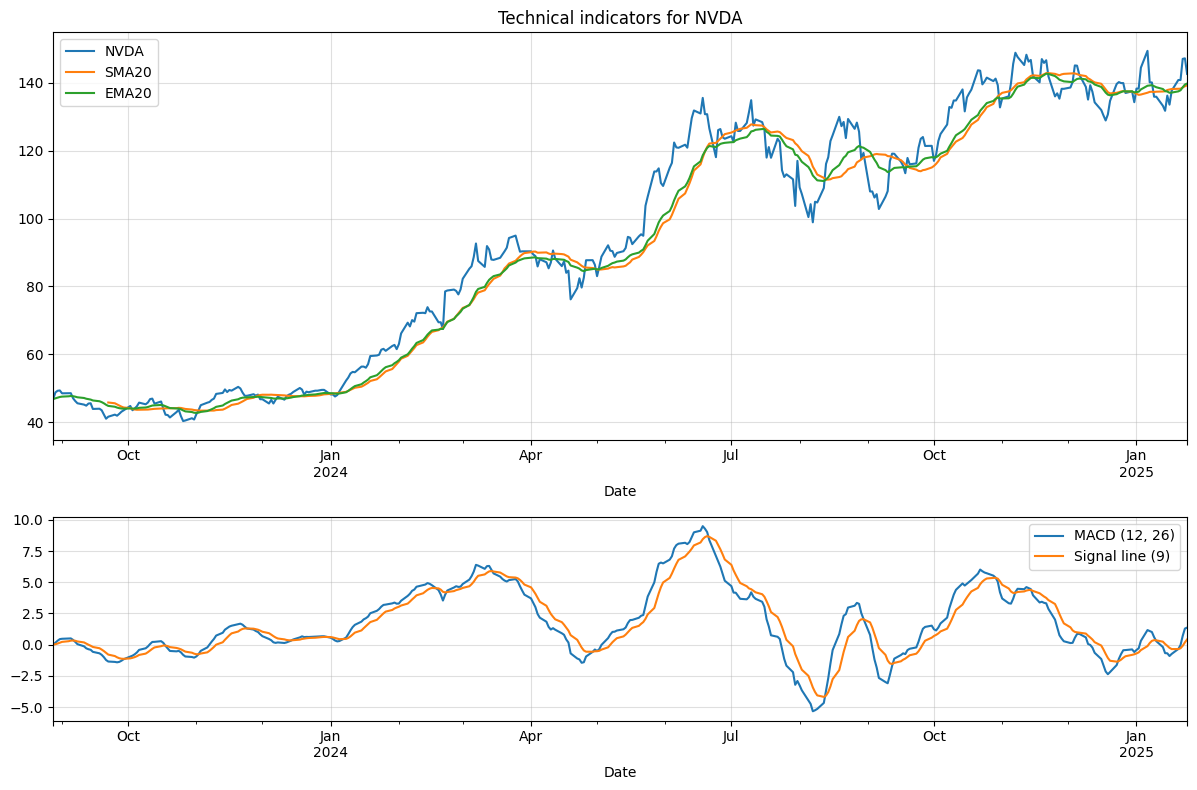

In [20]:
stock = 'NVDA'#'PBR'#'GE'
# rk.technical_indicators(stocks[stock], time_window=8, return_df=True, indicators=['SMA', 'EMA', 'MACD'], macd_params=[8, 17, 9])
rk.technical_indicators(stocks[stock], time_window=MA_terms, return_df=True, indicators=['SMA', 'EMA', 'MACD'], macd_params=[12, 26, 9])

### **Signals across all stocks**

In [21]:
signals = []
for stock in stocks.columns:
    stock_signals = rk.technical_indicators(stocks[stock], indicators=['SMA', 'EMA', 'MACD'], time_window=MA_terms, macd_params=[12, 26, 9], return_df=True, plot=False, signal_tolerance=.975).iloc[-1]
    stock_signals = pd.DataFrame(stock_signals).T
    stock_signals.index = [stock]
    stock_signals.rename(columns={stock: 'Price'}, inplace=True)
    signals.append(stock_signals)

signals = pd.concat(signals, axis=0)

In [22]:
signals

,Price,SMA20,EMA20,SMA20 Signal,EMA20 Signal,MACD Signal
BCOLOMBIA.CL,39920.0,37773.0,37835.9484,True,True,True
BHI.CL,299.0,299.65,300.271772,True,True,True
BOGOTA.CL,28000.0,27054.0,27154.104939,True,True,True
BVC.CL,10400.0,9909.5,9931.773814,True,True,True
CELSIA.CL,3660.0,3668.83269,3651.811936,True,True,False
CEMARGOS.CL,9980.0,10382.0,10206.552484,False,True,False
CNEC.CL,10340.0,11207.0,11078.82992,False,False,False
CONCONCRET.CL,582.0,606.6,587.498447,False,True,False
CORFICOLCF.CL,16700.0,15382.0,15594.926115,True,True,True
ECOPETROL.CL,1760.0,1804.75,1794.492052,True,True,False


### **Stock filtering by signal**

In [23]:
signals_filtered = signals[np.int64(signals['MACD Signal']) + np.int64(signals[f'SMA{MA_terms} Signal']) + np.int64(signals[f'EMA{MA_terms} Signal']) >= 2]

In [24]:
selected_stocks_rets = rets[signals_filtered.index]
selected_stocks_stocks = stocks[signals_filtered.index]

### **Export datasets and an index for the Sharpe-Ratio maximizing allocation**

In [25]:
# Selected stocks dataset
selected_stocks_rets.to_csv('selected_stocks_rets.csv')
selected_stocks_stocks.to_csv('selected_stocks_stocks.csv')

# Raw data datasets
col_rets_raw.to_csv('col_rets_raw.csv')
global_rets_raw.to_csv('global_rets_raw.csv')

# Concatenated returns and stock prices datasets
rets.to_csv('all_rets.csv')
stocks.to_csv('all_stocks.csv')